In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


df = pd.read_csv('../../data/processed/SalesRevenueProcessed.csv')
df.head()

,IsPromotionApplied,ProductionCost,MarketingSpend,SeasonalDemandIndex,CompetitorPrice,CustomerRating,EconomicIndex,StoreCount,ProductCategory_Electronics,ProductCategory_Furniture,ProductCategory_Toys,Region_North,Region_South,Region_West,CustomerSegment_Low Income,CustomerSegment_Middle Income,SalesRevenue
0,1.028403,0.369698,-0.235802,0.022636,-0.970258,0.88176,2.414633,0.114937,-0.596601,1.753089,-0.570422,-0.585819,-0.589668,-0.582739,-0.73622,-0.678911,2293.143707
1,-0.972381,-1.492378,1.085554,0.022636,2.059882,0.88176,0.223070,-0.472621,-0.596601,-0.570422,1.753089,-0.585819,-0.589668,1.716034,-0.73622,-0.678911,1640.454368
2,-0.972381,1.199536,1.526006,0.022636,0.784033,0.88176,-1.185792,-0.161561,1.676163,-0.570422,-0.570422,-0.585819,1.695868,-0.582739,-0.73622,-0.678911,2173.086023
3,1.028403,-1.623937,-0.956541,0.022636,-1.105204,0.88176,1.475392,-1.163866,-0.596601,1.753089,-0.570422,-0.585819,-0.589668,1.716034,-0.73622,1.472947,1672.608857
4,1.028403,-0.227381,-0.916500,1.763858,-0.307798,0.88176,0.588330,0.425997,-0.596601,1.753089,-0.570422,-0.585819,-0.589668,1.716034,-0.73622,1.472947,2443.222482


In [20]:
X = df.drop(columns=["SalesRevenue"])
y = df["SalesRevenue"]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"(X) Trainning Shape: {X_train.shape}")
print(f"(X) Test Shape: {X_test.shape}")

(X) Trainning Shape: (1600, 16)
(X) Test Shape: (400, 16)


Epoch 0/150, Loss: 4425667.1200
Epoch 20/150, Loss: 3103039.9300
Epoch 40/150, Loss: 216997.5338
Epoch 60/150, Loss: 51832.5528
Epoch 80/150, Loss: 37973.9825
Epoch 100/150, Loss: 29830.5788
Epoch 120/150, Loss: 24560.8137
Epoch 140/150, Loss: 21028.8721

=== NN (PyTorch) ===
MAE Train: 111.0339
MSE Train: 19676.0163
MAPE Train; 0.0551
R² Train: 0.8354

---
MAE Test: 113.3441
MSE Test: 20690.4801
MAPE Test: 0.0569
R² Test: 0.8278


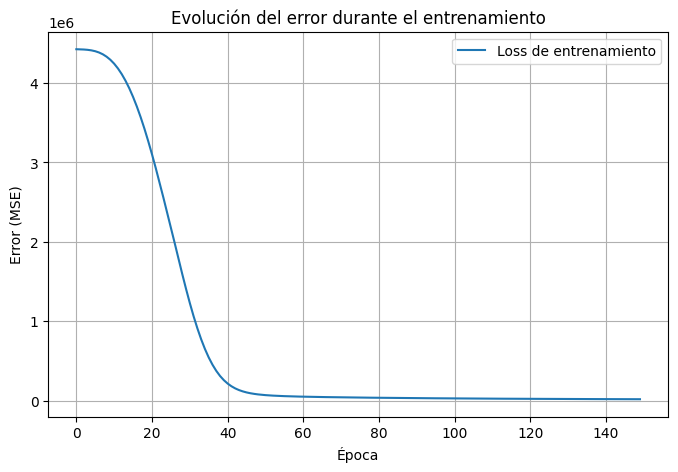

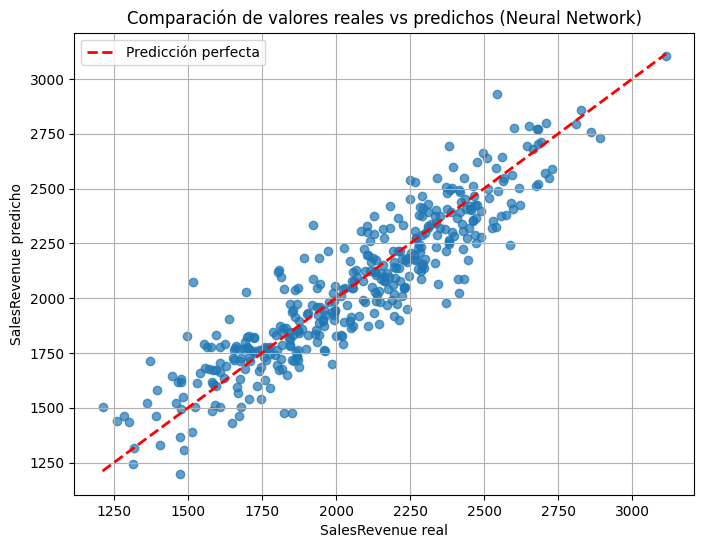

In [21]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, mean_absolute_percentage_error

X_train = X_train.astype(float)
X_test = X_test.astype(float)

X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

class SalesRevenueNN(nn.Module):
    def __init__(self, input_dim):
        super(SalesRevenueNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )

    def forward(self, x):
        return self.net(x)


input_dim = X_train.shape[1]
model = SalesRevenueNN(input_dim)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


epochs = 150
train_losses = []

for epoch in range(epochs):
    model.train()
    epoch_loss = 0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    train_losses.append(epoch_loss / len(train_loader))
    if epoch % 20 == 0:
        print(f"Epoch {epoch}/{epochs}, Loss: {epoch_loss / len(train_loader):.4f}")



model.eval()
with torch.no_grad():
    y_train_pred = model(X_train_tensor).numpy()
    y_pred = model(X_test_tensor).numpy()

mae_train = mean_absolute_error(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
mape_train = mean_absolute_percentage_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

mae_test = mean_absolute_error(y_test, y_pred)
mse_test = mean_squared_error(y_test, y_pred)
mape_test = mean_absolute_percentage_error(y_test, y_pred)
r2_test = r2_score(y_test, y_pred)

print("\n=== NN (PyTorch) ===")
print(f"MAE Train: {mae_train:.4f}")
print(f"MSE Train: {mse_train:.4f}")
print(f"MAPE Train; {mape_train:.4f}")
print(f"R² Train: {r2_train:.4f}")

print("\n---")
print(f"MAE Test: {mae_test:.4f}")
print(f"MSE Test: {mse_test:.4f}")
print(f"MAPE Test: {mape_test:.4f}")
print(f"R² Test: {r2_test:.4f}")


plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Loss de entrenamiento")
plt.xlabel("Época")
plt.ylabel("Error (MSE)")
plt.title("Evolución del error durante el entrenamiento")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', lw=2, label='Predicción perfecta')
plt.xlabel("SalesRevenue real")
plt.ylabel("SalesRevenue predicho")
plt.title("Comparación de valores reales vs predichos (Neural Network)")
plt.legend()
plt.grid(True)
plt.show()
